In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_ret(df):
    log_ret = df['Adj Close'].apply(np.log).diff().fillna(0).to_frame()
    sim_ret = df['Adj Close'].pct_change().fillna(0).to_frame()
    log_ret.columns = ['Log Ret']
    sim_ret.columns = ['Simple Ret']
    return pd.concat([df, log_ret, sim_ret], axis=1)

df_aapl = pd.read_csv(r'AAPL.csv', index_col='Date').iloc[0:-4]
df_aapl.index = pd.to_datetime(df_aapl.index, format='%Y-%m-%d')

df_ibm = pd.read_csv(r'IBM.csv', index_col='Date').iloc[0:-4]
df_ibm.index = pd.to_datetime(df_ibm.index, format='%Y-%m-%d')

df_jpm = pd.read_csv(r'JPM.csv', index_col='Date').iloc[0:-4]
df_jpm.index = pd.to_datetime(df_jpm.index, format='%Y-%m-%d')

df_dji = pd.read_csv(r'DJI.csv', index_col='Date').iloc[0:-4]
df_dji.index = pd.to_datetime(df_dji.index, format='%Y-%m-%d')

df_aapl = compute_ret(df_aapl)
df_ibm = compute_ret(df_ibm)
df_jpm = compute_ret(df_jpm)
df_dji = compute_ret(df_dji)

In [3]:
#question1

def get_robust_location_estimator(ps):
    return pd.DataFrame({
        'Median': ps.median()
    }, index=['Robust Location Estimator'])

def get_robust_scale_estimator(ps):
    q1 = ps.quantile(.25)
    q3 = ps.quantile(.75)
    return pd.DataFrame({
        'IQR': q3-q1,
        'MAD': (abs(ps - ps.median())).median()
    }, index=['Robust Scale Estimator'])

def get_all_estimators(ps, stock_name):
    q1 = ps.quantile(.25)
    q3 = ps.quantile(.75)
    return pd.DataFrame({
        'Median': ps.median(),
        'IQR': q3-q1,
        'MAD': (abs(ps - ps.median())).median()
    }, index=[stock_name])

aapl_estimators = get_all_estimators(df_aapl['Adj Close'], "AAPL")
ibm_estimators = get_all_estimators(df_ibm['Adj Close'], "IBM")
jpm_estimators = get_all_estimators(df_jpm['Adj Close'], "JPM")

all_stocks_estimators = pd.concat([aapl_estimators,ibm_estimators, jpm_estimators])
all_stocks_estimators

,Median,IQR,MAD
AAPL,184.411102,36.023727,15.709945
IBM,138.566391,14.709091,4.543045
JPM,107.506935,7.291882,3.626938


In [4]:
#question3

def add_outlier(df, date_list):
    temp_df = df.copy()
    outlier = 1.2 * df['Adj Close'].max()
    for d in date_list:
        temp_df['Adj Close'].loc[d] = outlier
    return temp_df

def get_error(df):
    median_error_list = []
    mad_error_list = []
    iqr_error_list = []

    ori_med = get_robust_location_estimator(df['Adj Close'])['Median']
    scale_est = get_robust_scale_estimator(df['Adj Close'])
    ori_mad = scale_est['MAD']
    ori_iqr = scale_est['IQR']

    percentage = [d / 100 for d in range(0, 61, 5)]
    for i in percentage:
        date_index_list = df['Adj Close'].sample(frac=i).index
        df_outlier = add_outlier(df, date_index_list)

        mod_med = get_robust_location_estimator(df_outlier['Adj Close'])['Median']

        mod_est = get_robust_scale_estimator(df_outlier['Adj Close'])
        mod_mad = mod_est['MAD']
        mod_iqr = mod_est['IQR']

        median_error_list.append(abs(mod_med - ori_med).values[0])
        mad_error_list.append(abs(mod_mad - ori_mad).values[0])
        iqr_error_list.append(abs(mod_iqr - ori_iqr).values[0])
        
    return median_error_list, mad_error_list, iqr_error_list

In [5]:
aapl_median_error, aapl_mad_error, aapl_iqr_error = get_error(df_aapl)
ibm_median_error, ibm_mad_error, ibm_iqr_error = get_error(df_jpm)
jpm_median_error, jpm_mad_error, jpm_iqr_error = get_error(df_jpm)

median_error_map = {
    "AAPL Median Error": aapl_median_error,
    "IBM Median Error": ibm_median_error,
    "JPM Median Error": jpm_median_error
}

mad_error_map = {
    "AAPL MAD Error": aapl_mad_error,
    "IBM MAD Error": ibm_mad_error,
    "JPM MAD Error": jpm_mad_error,
}

iqr_error_map = {
    "AAPL IQR Error": aapl_iqr_error,
    "IBM IQR Error": ibm_iqr_error,
    "JPM IQR Error": jpm_iqr_error,
}

percentage = [d / 100 for d in range(0, 61, 5)]
median_error = pd.DataFrame(median_error_map, index = percentage)
mad_error = pd.DataFrame(mad_error_map, index = percentage)
iqr_error = pd.DataFrame(iqr_error_map, index = percentage)

median_mean = median_error.mean(axis = 1).to_frame(name = "Mean of Median Error")
median_error = pd.concat([median_error, median_mean], axis=1)

mad_mean = mad_error.mean(axis = 1).to_frame(name = "Mean of MAD Error")
mad_error = pd.concat([mad_error, mad_mean], axis=1)

iqr_mean = iqr_error.mean(axis = 1).to_frame(name = "Mean of IQR Error")
iqr_error = pd.concat([iqr_error, iqr_mean], axis=1)

/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


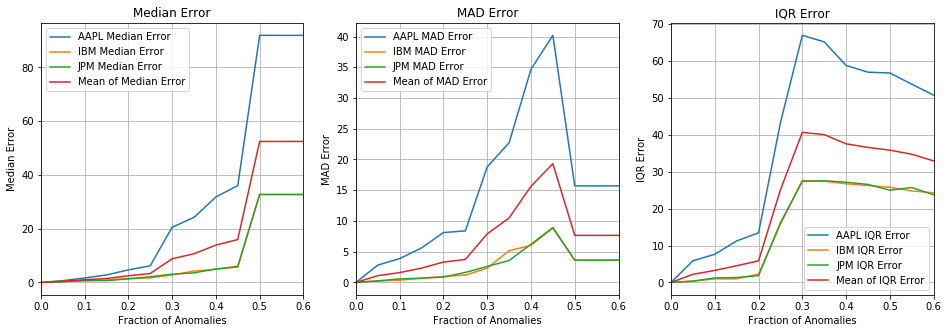

In [6]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

median_error.plot(ax = ax1)
ax1.grid()
ax1.set_title('Median Error')
ax1.set_xlabel('Fraction of Anomalies')
ax1.set_ylabel('Median Error')

mad_error.plot(ax = ax2)
ax2.grid()
ax2.set_title('MAD Error')
ax2.set_xlabel('Fraction of Anomalies')
ax2.set_ylabel('MAD Error')

iqr_error.plot(ax = ax3)
ax3.grid()
ax3.set_title('IQR Error')
ax3.set_xlabel('Fraction of Anomalies')
ax3.set_ylabel('IQR Error')

plt.savefig("images//all_error")